# 问题

实际处理和解决机器学习问题过程中，我们会遇到一些“大数据”问题，比如有上百万条数据，上千上万维特征，此时数据存储已经达到10G这种级别。这种情况下，如果还是直接使用传统的方式肯定行不通，比如当你想把数据load到内存中转成numpy数组，你会发现要么创建不了那么大的numpy矩阵，要么直接加载时报MemeryError。

在这种情况下我了解了几种选择办法，1. 对数据进行降维，2. 使用流式或类似流式处理，3. 上大机器，高内存的，或者用spark集群。

要实现big data的处理，需要满足三个条件：

    1. 有流式数据
    
    2. 能从数据中可以提取出特征
    
    3. 增量学习算法

1. 流式数据

    第一个条件，要给算法流式数据或小batch的数据，比如一次提供1000条这样。这一块是需要自己写代码提供的，可以实现一个生成器，每调用一次提供一份小batch数据。
    
2. 提取特征

    第二个条件，可以使用任何一种sklearn中支持的特征提取方法。对于一些特殊情况，比如特征需要标准化或者是事先不知道特征值的情况下需要特殊处理。

3. 增量学习算法

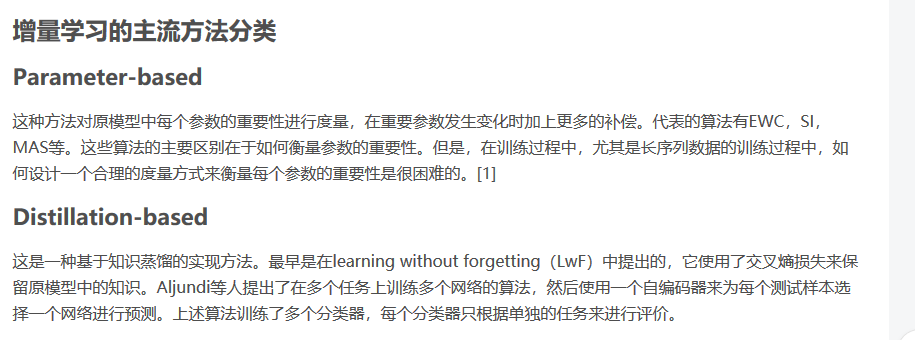

对于第三个条件，sklearn中提供了很多增量学习算法。虽然不是所有的算法都可以增量学习，但是学习器提供了 partial_fit的函数的都可以进行增量学习。事实上，使用小batch的数据中进行增量学习（有时候也称为online learning）是这种学习方式的核心，因为它能让任何一段时间内内存中只有少量的数据。
sklearn提供很多增量学习算法：

    Classification分类算法
        sklearn.naive_bayes.MultinomialNB
        sklearn.naive_bayes.BernoulliNB
        sklearn.linear_model.Perceptron
        sklearn.linear_model.SGDClassifier
        sklearn.linear_model.PassiveAggressiveClassifier
    Regression回归
        sklearn.linear_model.SGDRegressor
        sklearn.linear_model.PassiveAggressiveRegressor
    Clustering无监督
        sklearn.cluster.MiniBatchKMeans
    Decomposition / feature Extraction 
        sklearn.decomposition.MiniBatchDictionaryLearning
        sklearn.decomposition.IncrementalPCA
        sklearn.decomposition.LatentDirichletAllocation
        sklearn.cluster.MiniBatchKMeans

其中对于分类问题，在第一次调用partial_fit时需要通过classes参数指定分类的类别。

另外有一点需要考虑，所有的学习器在学习过程中不会对每个样例赋予同样的权重。对于感知机，它对于bad样本会敏感，即使学习器已经学习了很多样本了，而对于SGD和PassiveAggressive，对于这种情况会更鲁棒一点，后者在学习的时候，后来学习样本的权重会随着学习器学习率的下降而降低。

# partial_fit

In [54]:
import numpy as np
X1 = np.random.randn(1000).reshape(100, 10)
y1 = np.random.randint(0, 2, 100).reshape(100, 1)

X2 = np.random.randn(1000).reshape(100, 10)
y2 = np.random.randint(0, 2, 100).reshape(100, 1)

In [56]:
a = '123'
b = float(a)
type(b)

float

### 方案解决 

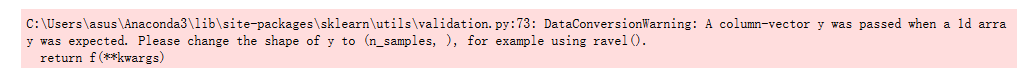

In [13]:
#train_y.values.ravel()

In [12]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='log')

#用数据集训练
clf.partial_fit(X1, y1.ravel(), classes=np.array([0, 1]))

#train_y.values.ravel()

#当我们有了新数据之后，可以在原基础上更新模型
clf.partial_fit(X2, y2.ravel(), classes=np.array([0, 1]))

#partial_fit的模型使用方法也是和正常模型一样的，直接用predict或者predict_proba
y_pred = clf.predict_proba(X2)
print(y_pred[:20] == y2[:20])

[[False False]
 [False False]
 [ True False]
 [ True False]
 [False  True]
 [False False]
 [ True False]
 [False False]
 [False False]
 [False False]
 [False  True]
 [False False]
 [ True False]
 [False False]
 [ True False]
 [False False]
 [False False]
 [False False]
 [False False]
 [ True False]]


# 1. 生成一个文件流迭代器

In [2]:
import numpy as np

# 生成模拟数据
x = np.random.randn(1000000).reshape(10000, 100)
y = np.random.randint(0, 2, 10000).reshape(10000, 1)
data = np.concatenate((y, x), axis=1)

np.savetxt("data.csv", data, delimiter=',')

In [3]:
import csv    #加载csv包便于读取csv文件

def iter_minibatches(data_stream, minibatch_size=100):
    '''
    迭代器(按照Minbatch的大小，将数据集重构，类似于pytorch中dataloader的功能)
    给定文件流（比如一个大文件），每次输出minibatch_size行，默认选择1k行
    将输出转化成numpy输出，返回X, y
    '''
    X = []
    y = []
    cur_line_num = 0

    csv_file=open(data_stream)    #打开csv文件
    csv_reader_lines = csv.reader(csv_file)   #逐行读取csv文件
    
    for line in csv_reader_lines:
        y.append(float(line[0]))
        X.append(line[1:])  # 这里要将数据转化成float类型

        cur_line_num += 1
        if cur_line_num >= minibatch_size:
            X, y = np.array(X), np.array(y)  # 将数据转成numpy的array类型并返回
            yield X, y # 中断函数的进行，并返回X, y
            X, y = [], []
            cur_line_num = 0
    csv_file.close()

In [4]:
# 生成测试文件
minibatch_test_iterators = iter_minibatches('data.csv', minibatch_size=100)

# ？？？待解决
#X_test, y_test = minibatch_test_iterators.next()  # 得到一份测试文件

# 得到一份测试文件
X_test = np.random.randn(10000).reshape(100, 100)
y_test = np.random.randint(0, 2, 100).reshape(100, 1)

# 2. 增量训练

对于第三个条件，sklearn中提供了很多增量学习算法。虽然不是所有的算法都可以增量学习，但是学习器提供了 partial_fit 的函数的都可以进行增量学习。事实上，使用小batch的数据中进行增量学习（有时候也称为online learning）是这种学习方式的核心，因为它能让任何一段时间内内存中只有少量的数据。
sklearn提供很多增量学习算法：

    Classification分类算法
        sklearn.naive_bayes.MultinomialNB
        sklearn.naive_bayes.BernoulliNB
        sklearn.linear_model.Perceptron
        sklearn.linear_model.SGDClassifier
        sklearn.linear_model.PassiveAggressiveClassifier
    Regression回归
        sklearn.linear_model.SGDRegressor
        sklearn.linear_model.PassiveAggressiveRegressor
    Clustering无监督
        sklearn.cluster.MiniBatchKMeans
    Decomposition / feature Extraction 
        sklearn.decomposition.MiniBatchDictionaryLearning
        sklearn.decomposition.IncrementalPCA
        sklearn.decomposition.LatentDirichletAllocation
        sklearn.cluster.MiniBatchKMeans

### 分类算法 

In [142]:
from sklearn.naive_bayes import MultinomialNB
model_cf = MultinomialNB() # 离散型朴素贝叶斯
# 必须保证输入矩阵X为正， 不能有负数

In [144]:
from sklearn.naive_bayes import BernoulliNB
model_cf = BernoulliNB() # 伯努利贝叶斯

In [5]:
from sklearn.naive_bayes import GaussianNB
model_cf = GaussianNB() # 离散型朴素贝叶斯

In [126]:
from sklearn.linear_model import Perceptron
model_cf = Perceptron() # 感知机

In [165]:
from sklearn.linear_model import SGDClassifier
model_cf = SGDClassifier()  # SGDClassifier(随机梯度下降) 的参数设置可以参考sklearn官网

In [146]:
from sklearn.linear_model import PassiveAggressiveClassifier
model_cf = PassiveAggressiveClassifier() # PA被动感知算法

In [6]:
minibatch_train_iterators = iter_minibatches("data.csv", minibatch_size=1000)

# 开始训练
for i, (X_train, y_train) in enumerate(minibatch_train_iterators):
    # 使用 partial_fit ，并在第一次调用 partial_fit 的时候指定 classes
    
    # 在使用BernoulliNB 时， 需要将换成float and int ，否则">"出错, 对其他方法，没有影响
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    
    # 在使用MultinomialNB 时， 需要将换成float and int, 对其他方法，没有影响
    #X_train = abs(X_train)
    
    model_cf.partial_fit(X_train, y_train, classes=np.array([0, 1]))
    print("{} time".format(i))  # 当前次数
    print("{} score".format(model_cf.score(X_test, y_test)))  # 在测试集上看效果

0 time
0.46 score
1 time
0.46 score
2 time
0.47 score
3 time
0.47 score
4 time
0.52 score
5 time
0.51 score
6 time
0.49 score
7 time
0.55 score
8 time
0.55 score
9 time
0.53 score


### 回归 

In [7]:
from sklearn.linear_model import SGDRegressor
model_reg = SGDRegressor()

In [52]:
from sklearn.linear_model import PassiveAggressiveRegressor
model_reg = PassiveAggressiveRegressor()

In [8]:
minibatch_train_iterators = iter_minibatches("data.csv", minibatch_size=1000)
# 开始训练
for i, (X_train, y_train) in enumerate(minibatch_train_iterators):
    # 使用 partial_fit ，并在第一次调用 partial_fit 的时候指定 classes
    model_reg.partial_fit(X_train, y_train)
    print("{} time".format(i))  # 当前次数
    print("{} score".format(model_reg.score(X_test, y_test)))  # 在测试集上看效果

0 time
-0.21478694500631512 score
1 time
-0.03936852530952906 score
2 time
-0.09663401509789127 score
3 time
-0.04568203681759164 score
4 time
-0.03222076223285142 score
5 time
-0.03652296278218148 score
6 time
-0.0883185309489456 score
7 time
-0.08086223304868678 score
8 time
-0.10232792910463218 score
9 time
-0.05053084121508977 score


### 无监督 / 聚类

In [9]:
from sklearn.cluster import MiniBatchKMeans
model_cluster = MiniBatchKMeans()

In [10]:
minibatch_train_iterators = iter_minibatches("data.csv", minibatch_size=1000)
# 开始训练
for i, (X_train, y_train) in enumerate(minibatch_train_iterators):
    # 使用 partial_fit ，并在第一次调用 partial_fit 的时候指定 classes
    model_cluster.partial_fit(X_train, y_train)
    print("{} time".format(i))  # 当前次数
    print("{} score".format(model_cluster.score(X_test, y_test)))  # 在测试集上看效果

0 time
-9821.091904158535 score
1 time
-9818.417888770275 score
2 time
-9810.178533994418 score
3 time
-9814.191059337536 score
4 time
-9813.728019817698 score
5 time
-9812.438205653225 score
6 time
-9809.52672011951 score
7 time
-9806.895915572906 score
8 time
-9807.19585187929 score
9 time
-9807.458135791612 score


### 待解决： 分解/特征提取(Decomposition / feature Extraction)

In [152]:
from sklearn.decomposition import MiniBatchDictionaryLearning
model_decompos = MiniBatchKMeans()

In [158]:
from sklearn.decomposition import IncrementalPCA
model_decompos = IncrementalPCA()

In [161]:
from sklearn.decomposition import LatentDirichletAllocation
model_decompos = LatentDirichletAllocation()

In [162]:
minibatch_train_iterators = iter_minibatches("data.csv", minibatch_size=100)
# 开始训练
for i, (X_train, y_train) in enumerate(minibatch_train_iterators):
    # 使用 partial_fit ，并在第一次调用 partial_fit 的时候指定 classes
    model_decompos.partial_fit(X_train, y_train)
    print("{} time".format(i))  # 当前次数
    #print("{} score".format(model_decompos.score(X_test, y_test)))  # 在测试集上看效果

C:\Users\asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  return f(**kwargs)


TypeError: cannot perform reduce with flexible type